In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os

In [6]:
path = "./indices_FR_AX/index_asle_AX.txt"

data = pd.read_csv(path, sep=" ", header=None)
data_types = [float, float, float, float, int]
columns = ["LF", "MF", "HF", "Displacement", "Disk"]
data.columns = columns
data

,LF,MF,HF,Displacement,Disk
0,63.135850,100.910003,128.078314,1.0,1.0
1,63.732861,101.725100,127.437836,15.0,3.0
2,63.713974,101.414201,127.741550,7.5,2.0
3,63.697607,101.254199,127.905861,3.5,4.0
4,63.718422,101.484841,126.793883,14.0,1.0
...,...,...,...,...,...
150,63.645495,101.199991,128.017905,1.5,1.0
151,63.712468,101.392559,127.805760,7.0,2.0
152,63.733725,101.740096,127.429785,15.5,3.0
153,63.692493,101.228974,127.897437,3.0,4.0


In [7]:
x_df = data[['LF', 'MF', 'HF']]
y_df = data[['Displacement', 'Disk']]

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(x_df, y_df, random_state=42, test_size=0.20)

print(y_train.shape)
print(y_test.shape)

(124, 2)
(31, 2)


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [10]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(x_train.columns),))
    first_dense = Dense(units='128', activation='sigmoid')(input_layer)
    second_dense = Dense(units='128', activation='sigmoid')(first_dense)
    third_dense = Dense(units='128', activation='sigmoid')(second_dense)
    # Y1 output will be fed from the first dense
    y1_output = Dense(units='1', name='Displacement')(third_dense)

    forth_dense = Dense(units='128', activation='sigmoid')(input_layer)
    fifth_dense = Dense(units='128', activation='sigmoid')(forth_dense)
    sixth_dense = Dense(units='128', activation='sigmoid')(fifth_dense)
    # Y2 output will be fed from the second dense
    y2_output = Dense(units='1', activation='sigmoid', name='Disk')(sixth_dense)

    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

    return model

In [11]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'Displacement': 'mse', 'Disk': 'mse'},
              metrics={'Displacement': tf.keras.metrics.RootMeanSquaredError(),
                       'Disk': tf.keras.metrics.RootMeanSquaredError()})

In [16]:
history = model.fit(x_train_scaled, y_train,
                    epochs=100, batch_size=5, validation_data=(x_test_scaled, y_test))

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 53.1187 - Displacement_loss: 13.0958 - Disk_loss: 40.0228 - Displacement_root_mean_squared_error: 3.6188 - Disk_root_mean_squared_error: 6.3264 - val_loss: 36.4355 - val_Displacement_loss: 9.0189 - val_Disk_loss: 27.4166 - val_Displacement_root_mean_squared_error: 3.0032 - val_Disk_root_mean_squared_error: 5.2361
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 53.0649 - Displacement_loss: 13.0421 - Disk_loss: 40.0228 - Displacement_root_mean_squared_error: 3.6114 - Disk_root_mean_squared_error: 6.3264 - val_loss: 36.4432 - val_Displacement_loss: 9.0266 - val_Disk_loss: 27.4166 - val_Displacement_root_mean_squared_error: 3.0044 - val_Disk_root_mean_squared_error: 5.2361
Epoch 3/100
25/25 [==============================] - 0s 952us/step - loss: 53.2737 - Displacement_loss: 13.2509 - Disk_loss: 40.0228 - Displacement_root_mean_squared_error: 3.6402 - Disk_root_mean_squared_error: 6.3264 - val

In [13]:
# Test the model and print loss and rmse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=x_test_scaled, y=y_test)

print()
print(f'loss: {loss}')
print(f'price_loss: {Y1_loss}')
print(f'ptratio_loss: {Y2_loss}')
print(f'price_rmse: {Y1_rmse}')
print(f'ptratio_rmse: {Y2_rmse}')

1/1 [==============================] - 0s 14ms/step - loss: 36.2126 - Displacement_loss: 8.7960 - Disk_loss: 27.4166 - Displacement_root_mean_squared_error: 2.9658 - Disk_root_mean_squared_error: 5.2361

loss: 36.21262741088867
price_loss: 8.795990943908691
ptratio_loss: 27.416635513305664
price_rmse: 2.965803861618042
ptratio_rmse: 5.236089706420898


In [14]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

1/1 [==============================] - 0s 11ms/step


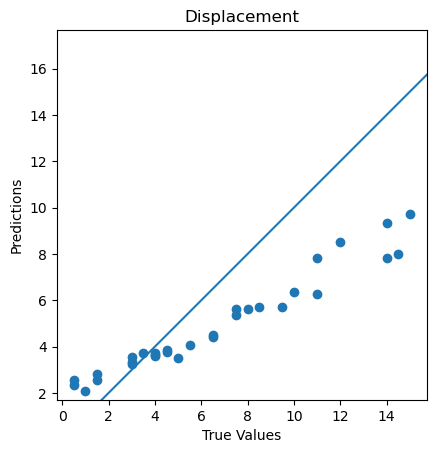

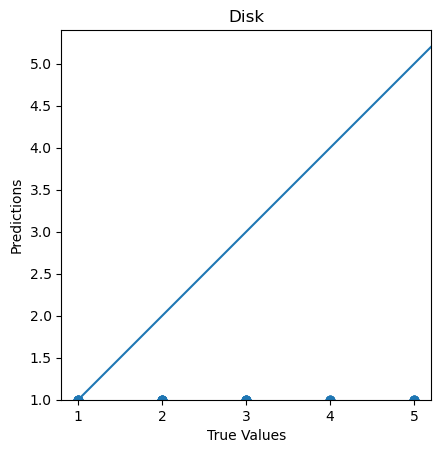

In [17]:
# Run predict
Y_pred = model.predict(x_test_scaled)
disp = Y_pred[0]
disk = Y_pred[1]

plot_diff(y_test['Displacement'], Y_pred[0], title='Displacement')
plot_diff(y_test['Disk'], Y_pred[1], title='Disk')

In [22]:
Y_pred

[array([[ 2.3885965],
        [ 6.3251486],
        [ 4.2337484],
        [ 6.351773 ],
        [ 7.04756  ],
        [ 8.426527 ],
        [ 6.4050446],
        [ 8.387428 ],
        [ 3.7709544],
        [10.31386  ],
        [ 5.2004695],
        [ 4.35262  ],
        [ 4.3723345],
        [ 4.196902 ],
        [ 4.4934664],
        [ 2.670601 ],
        [ 9.907281 ],
        [ 5.1302266],
        [ 4.7291656],
        [ 6.9852605],
        [ 9.057913 ],
        [ 3.8921878],
        [ 6.4677906],
        [ 3.2282617],
        [ 4.332683 ],
        [ 3.9989393],
        [ 8.588892 ],
        [ 6.060786 ],
        [ 2.8974428],
        [ 4.1473427],
        [ 2.8640335]], dtype=float32),
 array([[0.99982136],
        [0.9998193 ],
        [0.9998194 ],
        [0.9998195 ],
        [0.99982   ],
        [0.9998199 ],
        [0.99981976],
        [0.9998193 ],
        [0.9998197 ],
        [0.99981904],
        [0.99981916],
        [0.99981934],
        [0.99981934],
        [0.9998

In [20]:
y_test

,Displacement,Disk
81,0.5,5.0
142,7.5,5.0
31,4.0,2.0
29,8.0,3.0
118,10.0,2.0
60,14.0,2.0
93,8.5,2.0
147,11.0,4.0
153,3.0,4.0
68,15.0,5.0
